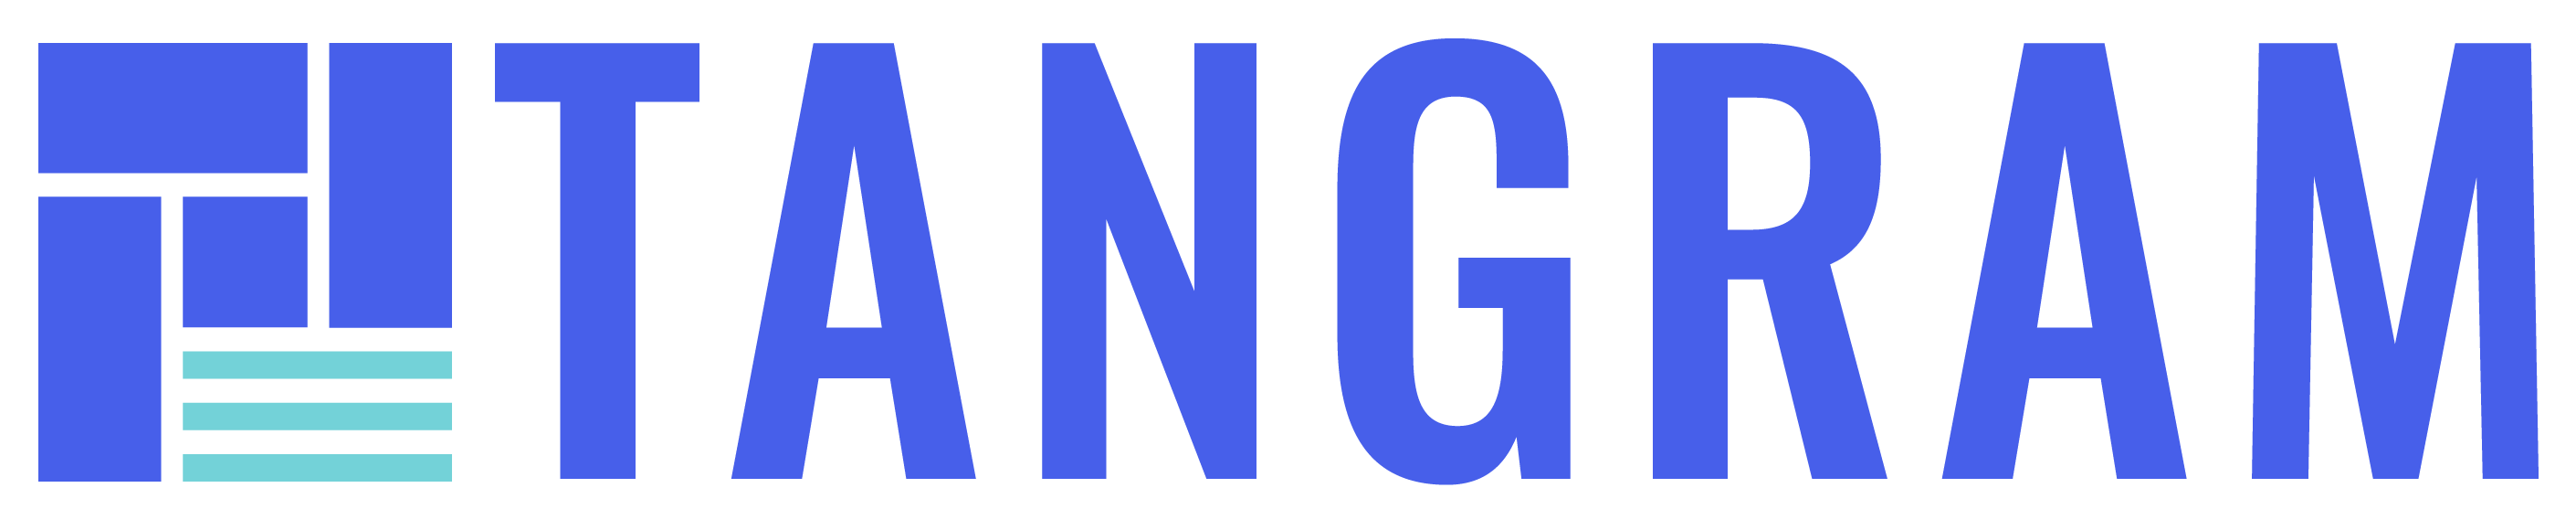

# Hands-on session on spatial mapping using Tangram

Adapted from the Tutorial for spatial mapping using _Tangram_ by Ziqing Lu <luz21@gene.com> and Tommaso Biancalani <biancalt@gene.com>.

Tangram is a Python package, written in [PyTorch](https://pytorch.org/) and based on [scanpy](https://scanpy.readthedocs.io/en/stable/), for mapping single-cell (or single-nucleus) gene expression data onto spatial gene expression data. The single-cell dataset and the spatial dataset should be collected from the same anatomical region/tissue type, ideally from a biological replicate, and need to share a set of genes. Tangram aligns the single-cell data in space by fitting gene expression on the shared genes.

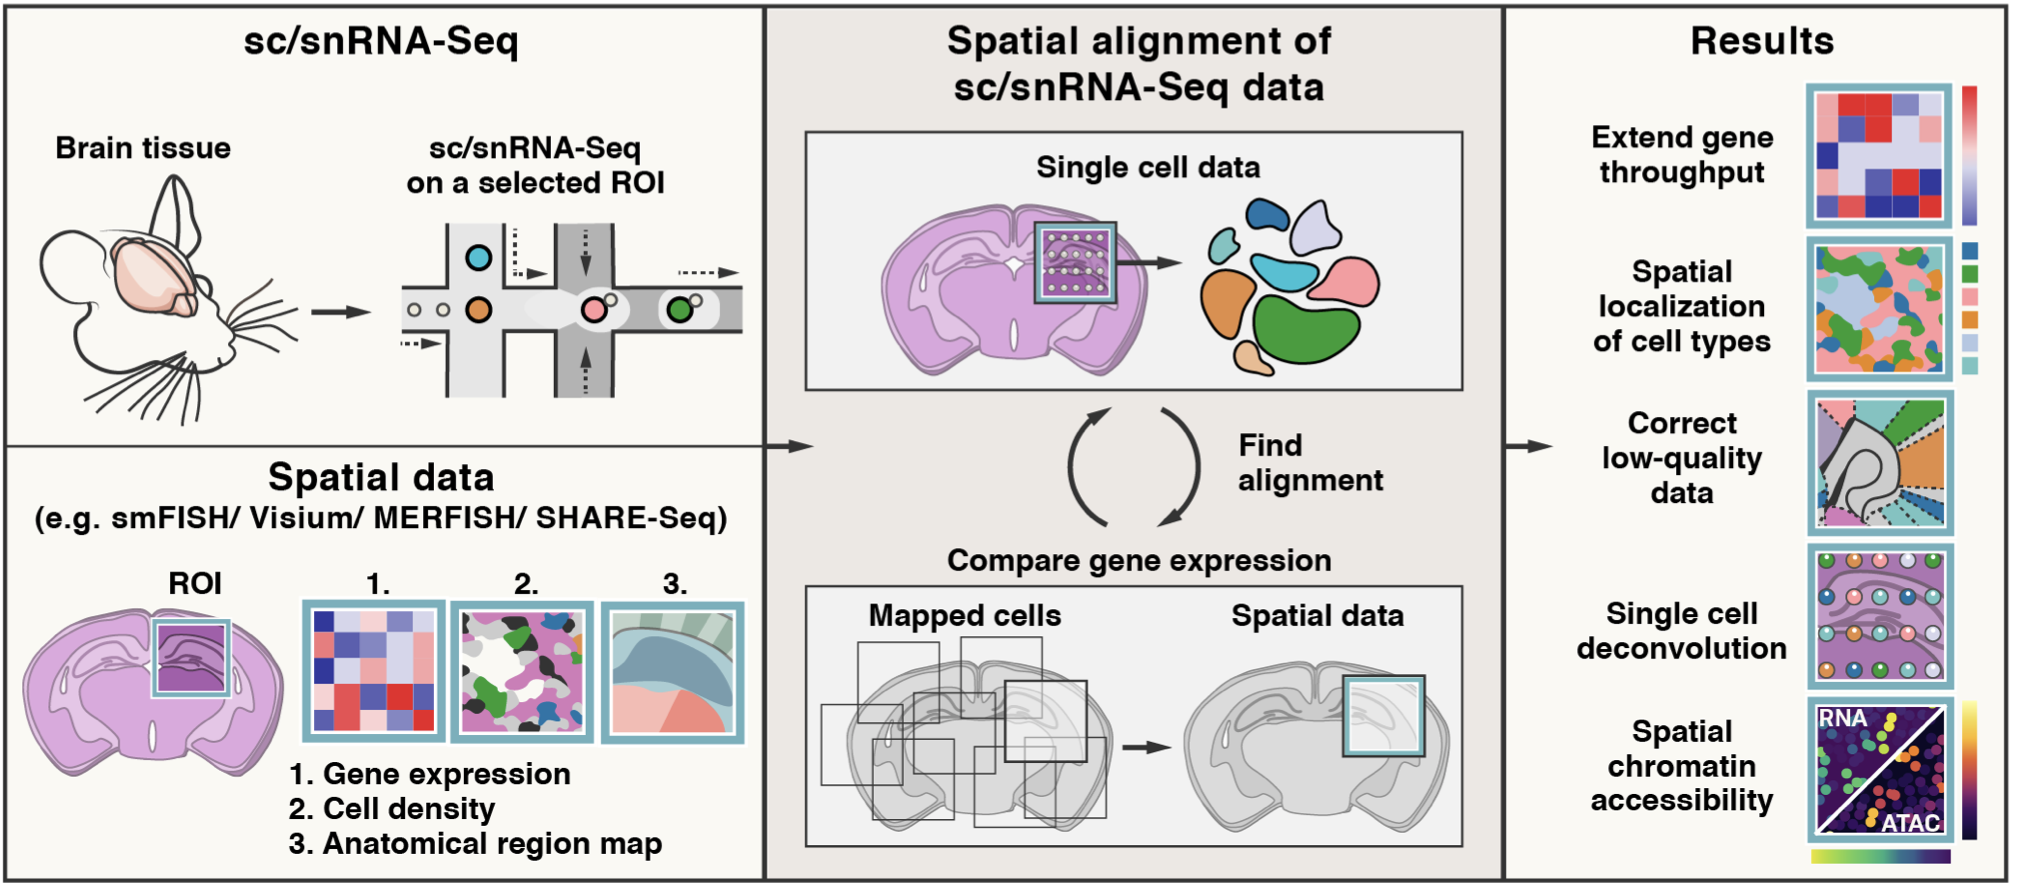

## How Tangram works under the hood

### 1. Preprocessing

Tangram takes two `AnnData` objects as input:

* **Single-cell expression matrix** $S \in \mathbb{R}^{n_{\text{cells}} \times n_{\text{genes}}}$
* **Spatial expression matrix** $G \in \mathbb{R}^{n_{\text{spots}} \times n_{\text{genes}}}$

To ensure comparability, Tangram uses `tg.pp_adatas`, which finds the intersection of genes and if `genes` is provided, further subsets the intersected genes to this list.

### 2. Mapping algorithm

Tangram's output is another `AnnData` object consisting of a **mapping probability matrix** $\hat M \in [0,1]^{n_{\text{cells}} \times n_{\text{spots}}}$ such that $\sum_{j=1}^{n_{\text{spots}}} \hat M_{ij} = 1$ and $0 \leq \hat M_{ij} \leq 1$. These constraints are enforced by applying the softmax to the unconstrained score matrix $\tilde M$ with $\hat M_{ij} = \text{softmax}(\tilde M)_{ij}$.

In Python, the core mapping is run via `tg.map_cells_to_space`, where Tangram learns $\hat M$ by minimizing an objective function via stochastic gradient descent.

#### Default objective

The default loss function is defined as the cosine distance between predicted and observed spatial gene expression:
$$
\Phi (\hat M) = - \frac{1}{n_{\mathrm{genes}}} \sum_{k=1}^{n_{\text{genes}}} \operatorname{cosine similarity}\big( (\hat M^\top S)_{*,k}, \; G_{*,k} \big)
$$

#### Extended objective

This formulation can be extended via hyperparameter:
$$
\begin{aligned}
\Phi (\hat M) = & - \lambda_{\text{g1}} \cdot \frac{1}{n_{\text{genes}}} \sum_{k=1}^{n_{\text{genes}}} \operatorname{cosine similarity}\big( (\hat M^\top S)_{*,k}, G_{*,k} \big) \\
& - \lambda_{\text{g2}} \cdot \frac{1}{n_{\text{spots}}} \sum_{j=1}^{n_{\text{spots}}} \operatorname{cosine similarity}\big( (\hat M^\top S)_{j,*}, G_{j,*} \big) \\
& + \lambda_{\text{d}} \cdot \text{KL}\big( \hat d, d \big) \\
& + \lambda_{\text{r}} \cdot \text{entropy}(\hat M)
\end{aligned}
$$

Where:
* Cosine distance per spot instead of gene is added,
* density term enforces that the learned density distribution $\hat d$ is as similar as possible to an expected density $d$ by default estimated by using the spatial gene expression counts, and
* entropy term encourages sparse mappings.

#### Additional mapping modes

* **Cluster Mode** (`mode='clusters'`) maps average expression profiles of cell clusters to spatial spots.
* **Constrained Mode** (`mode='constrained'`) introduces a learnable cell filter vector $\hat f$ to select an optimal subset of cells for mapping.
  A sigmoid transformation ensures $0 \leq \hat f \leq 1$. The mapping and expression matrices are adjusted to: $S = \mathrm{diag}(\hat f) \cdot S$, and $\hat M = \mathrm{diag}(\hat f) \cdot \hat M$ and regularization terms are added to the loss function $\Phi_{\hat f} (\hat M)$:

  $$
  \begin{aligned}
  \Phi_{\hat f} (\hat M) = \Phi (\hat M) + \lambda_{\operatorname{f_reg}} \cdot \sum_{i=1}^{n_{\text{cells}}} (\hat f_i - \hat f_i^2)
  + \lambda_{\text{count}} \cdot \left| \sum_{i=1}^{n_{\text{cells}}} \hat f_i - n_{\operatorname{target cells}} \right|
  \end{aligned}
  $$

  promoting near-binary filter values and enforcing a target number of selected cells $n_{\text{target cells}}$.
  The returned `AnnData` object contains the cell filter as vector in `obs['F_out']`.

### 3. Annotations transfer

Once $\hat M$ is learned, Tangram enables spatial projection of gene expression with `tg.project_genes`, cell-type annotations with `tg.project_cell_annotations` or other modalities $A$ by computing $M^\top A$.

## Task 1: Mapping of mouse brain Visium data

This exercise will introduce several methods of *Tangram* to provide an overview on it's use cases. 

### Setting up

In [ ]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

datadir = '../../datasets/Hands_on_4_Tangram/Task_1/'

### Loading datasets
Load public data available in Squidpy, from mouse brain cortex. The pre-processed single cell dataset was taken from <cite data-cite="tasic2018shared">Tasic et al. (2018)</cite> and pre-processed with standard scanpy functions. Single cell data are stored in `adata_sc`. Spatial data, in `adata_st`. We subset the crop of the mouse brain to only contain clusters of the brain cortex.  


In [ ]:
adata_st = sq.datasets.visium_fluo_adata_crop()
adata_st = adata_st[
    adata_st.obs.cluster.isin([f"Cortex_{i}" for i in np.arange(1, 5)])
].copy()
img = sq.datasets.visium_fluo_image_crop()

adata_sc = sq.datasets.sc_mouse_cortex()

In [ ]:
adata_st.obs

Let's visualize both spatial and single-cell datasets.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sc.pl.spatial(
    adata_st, color="cluster", alpha=0.7, frameon=False, show=False, ax=axs[0]
)
sc.pl.umap(
    adata_sc, color="cell_subclass", size=10, frameon=False, show=False, ax=axs[1]
)
plt.tight_layout()

### Preprocessing


_Tangram_ aligns single-cell data in space using a subset of user-specified genes, referred to as training genes. To obtain meaningful results, select genes that carry strong biological signal and are measured with high quality. A common strategy is to use 100–1000 differentially expressed genes, stratified across cell types. In some cases, the entire transcriptome can be used instead. It is also good practice to repeat the mapping with different sets of training genes in order to evaluate how robust the results are to changes in gene selection.

A common method for cell type marker identification is *Scanpy's* `rank_genes_groups`. This takes a while, so we computed this code for you: 

```python
sc.tl.rank_genes_groups(adata_sc, groupby="cell_subclass", use_raw=False)
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
markers = list(np.unique(markers_df.melt().value.values))
marker_df = pd.DataFrame({'markers': markers})
marker_df.to_csv('markers.csv')
```

So you can load the marker list: 

In [ ]:
markers = pd.read_csv(os.path.join(datadir, 'markers.csv'))['markers'].tolist()
len(markers)

**Task:** Prepare the data with `pp_adatas`, which selects the training genes from the `genes` argument, records them under `uns["training_genes"]`, and enforces a consistent gene order across datasets. Genes that are absent, all-zero, or inconsistently named between datasets are removed. By default, all gene names are converted to lowercase to avoid capitalization mismatches.

<div style="
    background-color: #e6f3ff;
    border-left: 4px solid #2196F3;
    padding: 10px 15px;
    border-radius: 5px;
    margin: 10px 0;
">
<b>💡 Hint:</b> You can quickly check the documentation of a function using e.g., <code>?tg.pp_adatas</code>:
</div>


In [ ]:
?tg.pp_adatas

In [ ]:
# tg.pp_adatas(XXX, XXX, genes=XXX)

### Mapping cells into space

Compute the spatial alignment with `map_cells_to_space`.
It optimizes the mapping over `num_epochs`, where we typically interrupt mapping after the score plateaus.
Key hyperparameters include `learning_rate`, `lambda_d` (weight of cell density prior), `lambda_g1` and `lambda_g2` (weights for gene-voxel similarity terms), and `lambda_r` (entropy regularizer).
Cell density across voxels is controlled via `density_prior`, which defaults to `rna_count_based` but can be set to `uniform` for single-cell resolution data (e.g. MERFISH) or supplied as a custom array.
The default `mode` is `cells`, but `clusters` can be used to map aggregated cells by a chosen `cluster_label`, which is faster and preferred when single-cell and spatial data come from different specimens.

The function returns a cell-by-spot `AnnData` object with mapping probabilities. The cell-by-spot matrix `X` contains the probability of cell $i$ being assigned to spot $j$.

This code runs a while, so we computed the mapping for you like this: 

```python
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    mode="cells",
    density_prior='rna_count_based',
    num_epochs=500,
    device='cpu',
)
```

```
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 1280 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.
Score: 0.613, KL reg: 0.001
Score: 0.733, KL reg: 0.000
Score: 0.736, KL reg: 0.000
Score: 0.737, KL reg: 0.000
Score: 0.737, KL reg: 0.000
INFO:root:Saving results..
```

The mapping results are stored in the returned `AnnData` structure, saved as `ad_map`, structured as following:
- The cell-by-spot matrix `X` contains the probability of cell `i` to be in spot `j`.
- The `obs` dataframe contains the metadata of the single cells.
- The `var` dataframe contains the metadata of the spatial data.
- The `uns` dictionary contains a dataframe with various information about the training genes (saved as `train_genes_df`).

Now load it: 

In [ ]:
ad_map = sc.read_h5ad(os.path.join(datadir, "ad_map.h5ad"))
ad_map

### Exploring training gene scores

To inspect mapping quality at the gene level, Tangram stores summary statistics for each training gene in the dataframe `uns['train_genes_df']` of the mapping `AnnData` object.

In [ ]:
ad_map.uns['train_genes_df']

This table lists the mapping scores together with sparsity information from both scRNA-seq and spatial data, and is the basis for Tangram's diagnostic plots. Explore these metrics is with `plot_training_scores`. This function generates four panels:
* Panel 1: histogram of similarity scores across all training genes.
* Panel 2: mapping score (y-axis) versus gene sparsity in the scRNA-seq data (x-axis).
* Panel 3: same as panel 2, but with sparsity in the spatial data, which is usually higher and often limits mapping quality.
* Panel 4: mapping score as a function of sparsity difference between the two datasets. For genes with comparable sparsity, the mapped gene expression is very similar to that in the spatial data. However, if a gene is quite sparse in one dataset (typically, the spatial data) but not in other, the mapping score is lower. This occurs as Tangram cannot properly matched the gene pattern because of inconsistent amount of dropouts between the datasets.

**Task**: Run `plot_training_scores` on the mapping matrix. 

In [ ]:
# tg.plot_training_scores(XXX, bins=20, alpha=.5)

### Improving spatial data by projecting single-cell gene expression into space

If the mapping mode is `'cells'`, we can generate "new spatial data" using the mapped single cells via `project_genes`. The result is a voxel-by-gene `AnnData` object, formally similar to spatial data, but containing gene expression from the mapped single cell data rather than Visium.

**Task**: Project the cells expression data to voxels. 

In [ ]:
# ad_ge = tg.project_genes(XXX, XXX)
# ad_ge

#### Inspecting training genes with low mapping scores

These are training genes with expecially low training scores. 

In [ ]:
genes = ['rragb', 'trim17', 'eno1b']
ad_map.uns['train_genes_df'].loc[genes]

**Task**: Visualize these genes with the function `plot_genes_sc`.

In [ ]:
# tg.plot_genes_sc(XXX, adata_measured=XXX, adata_predicted=XXX, perc=0.02)

The above pictures explain the low training scores. Some genes are detected with very different levels of sparsity - typically they are much more sparse in the spatial data than in the scRNAseq. This is due to the fact that technologies like Visium are more prone to technical dropouts. Therefore, _Tangram_ cannot find a good spatial alignment for these genes as the baseline signal is missing. However, so long as _most_ training genes are measured with high quality, we can trust mapping and use _Tangram_ prediction to correct gene expression. This is an imputation method which relies on entirely different premises than those in probabilistic models.

#### Predicting genes not measured in spatial data

So far, we have focused on training genes used to align the data, but the mapped single-cell data contains the full transcriptome.
Tangram can predict genes that were not detected in the spatial dataset but are present in the single-cell data. These genes are removed during preprocessing, but their spatial expression can still be inferred.
Here are a view example genes: 

In [ ]:
genes=['loc102633833', 'gm5700', 'gm8292']

**Task**: Visualize these genes with `plot_genes_sc`.

In [ ]:
# tg.plot_genes_sc(...)

#### Exploring testing gene scores

**Task:** 
To systematically evaluate all genes, let's compute similarity scores with `compare_spatial_geneexp`. This function returns a dataframe containing similarity scores for all genes that help us interpreting the performance.

In [ ]:
# df_all_genes = tg.compare_spatial_geneexp(...)

In [ ]:
sns.scatterplot(data=df_all_genes, x='score', y='sparsity_sp', hue='is_training', alpha=.5)
plt.show()

The produced figure is the most important validation plot. Unsurprisingly, the genes predicted with low score represents very sparse genes in the spatial data, suggesting that the _Tangram_ predictions correct expression in those genes.

Let's inspect a few predictions. Some of these genes are biologically sparse, but well predicted.

In [ ]:
genes=['tfap2b', 'zic4']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

Some non-sparse genes present patterns, that _Tangram_ accentuates.

In [ ]:
genes = ['cd34', 'rasal1']
tg.plot_genes_sc(genes, adata_measured=adata_st, adata_predicted=ad_ge, perc=0.02)

### Projecting cell types into space

**Task**: To visualize cell types in space, use `project_cell_annotation` to transfer the cell annotation from the mapping onto spatial coordinates. The resulting spatial probablity maps can then be displayed with `plot_cell_annotation_sc`. The `perc` parameter controls the colormap range, allowing outliers to be clipped for clearer visualization.

In [ ]:
# tg.project_cell_annotations(XXX, XXX, annotation="cell_subclass")
# annotation_list = list(pd.unique(adata_sc.obs['cell_subclass']))
# tg.plot_cell_annotation_sc(XXX, XXX, perc=0.02)

The plots show, that cortical layers of excitatory neurons were recovered. 
Also, as expected, Oligodentrocytes are concentrated in subcortical layers. 
VLMCs are specifically expressed in the first cortical layer, which is clearly visible in this plot. 
This shows, that the Tangram mapping worked well well. 